# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
holding

,Price in USDT,Weights in %
Total,1890.929343,1.000000e+00
BTCUSDT,772.346074,4.084479e-01
JASMYUSDT,277.222182,1.466063e-01
SOLUSDT,276.265370,1.461003e-01
OMUSDT,219.527601,1.160951e-01
ETHUSDT,184.922126,9.779431e-02
BBUSDT,107.036396,5.660518e-02
BNBUSDT,53.543342,2.831589e-02
TRXUSDT,0.066249,3.503509e-05
PEPEUSDT,0.000002,1.077565e-09


In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

1.0

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

### Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
LDUMAUSDT not retrieved
LDUMAUSDT


In [13]:
positions=positions.sort_index()

In [14]:
positions.index=pd.to_datetime(positions.index)

In [15]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [16]:
positions.to_excel('Positions.xlsx')

In [17]:
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

In [18]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()

binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [19]:
historical_ptf=pd.DataFrame()

In [20]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

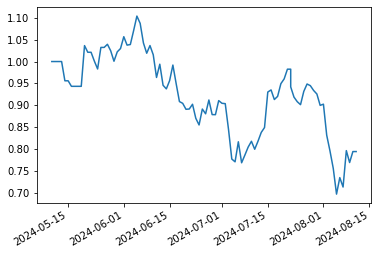

In [21]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [22]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [23]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use)
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [24]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT', 'ENSUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT',
       'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'NEXOUSDT', 'OMUSDT',
       'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SANDUSDT',
       'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT',
       'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT',
       'WBTCUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT', 'ZECUSDT'],
      dtype='object')

In [25]:
limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [26]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
OMUSDT,0.473509
BTCUSDT,0.400000
PEPEUSDT,0.080965
JASMYUSDT,0.039377
BNBUSDT,0.006149


In [27]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [28]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
OMUSDT,0.6
BTCUSDT,0.4


## Real Portfolio vs Optimal

In [29]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,772.346074,4.084479e-01,0.4,0.008448
JASMYUSDT,277.222182,1.466063e-01,0.0,0.000000
SOLUSDT,276.265370,1.461003e-01,0.0,0.000000
OMUSDT,219.527601,1.160951e-01,0.6,-0.483905
ETHUSDT,184.922126,9.779431e-02,0.0,0.000000
BBUSDT,107.036396,5.660518e-02,0.0,0.000000
BNBUSDT,53.543342,2.831589e-02,0.0,0.000000
TRXUSDT,0.066249,3.503509e-05,0.0,0.000000
PEPEUSDT,0.000002,1.077565e-09,0.0,0.000000


In [30]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,772.346074,4.084479e-01,0.400000,0.008448
JASMYUSDT,277.222182,1.466063e-01,0.039377,0.107229
SOLUSDT,276.265370,1.461003e-01,0.000000,0.000000
OMUSDT,219.527601,1.160951e-01,0.473509,-0.357414
ETHUSDT,184.922126,9.779431e-02,0.000000,0.000000
BBUSDT,107.036396,5.660518e-02,0.000000,0.000000
BNBUSDT,53.543342,2.831589e-02,0.006149,0.022167
TRXUSDT,0.066249,3.503509e-05,0.000000,0.000000
PEPEUSDT,0.000002,1.077565e-09,0.080965,-0.080965


## Risk Reward Analysis

In [31]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [32]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

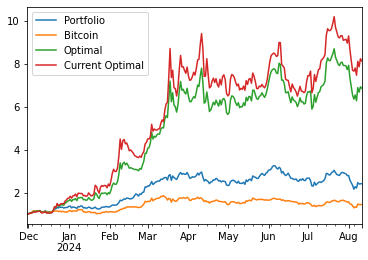

In [33]:
(1+portfolio_perf).cumprod().plot()

In [34]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

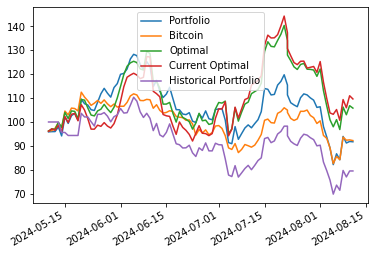

In [35]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [36]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.767567
dtype: float64

In [37]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.586726
dtype: float64

In [38]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.536352
Bitcoin            0.453406
Optimal            0.769028
Current Optimal    0.873750
dtype: float64

In [39]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.298092620148783

In [40]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.000705,0.001250,0.001676,0.000017,0.001659
BTCUSDT,0.020111,0.058148,0.148381,0.055617,0.092764
JASMYUSDT,0.005874,0.009229,0.022065,0.003486,0.018579
OMUSDT,0.953288,0.905249,0.761642,0.670088,0.091553
PEPEUSDT,0.020022,0.026124,0.066236,0.020477,0.045759


In [41]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.466056,0.398079,0.269688,0.088475,0.181213
JASMYUSDT,0.133025,0.147909,0.239687,0.079803,0.159884
SOLUSDT,0.122110,0.148570,0.158675,0.033559,0.125116
OMUSDT,-0.607950,0.161590,0.117241,0.032976,0.084265
ETHUSDT,0.254553,0.088561,0.081944,0.009636,0.072308
BBUSDT,0.556747,0.028669,0.112283,0.025519,0.086764
BNBUSDT,0.075459,0.026623,0.020481,0.000604,0.019878


## Value At Risk

### Historical

In [42]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.06401478226993593, -0.09084109853509871)

In [43]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05198675594727819, -0.0745878241700001)

In [44]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [45]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.016719
JASMYUSDT   -0.011372
SOLUSDT     -0.012224
OMUSDT      -0.005178
ETHUSDT     -0.004441
BBUSDT      -0.002429
BNBUSDT     -0.002043
TRXUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.054406
Name: 2024-07-07 00:00:00, dtype: float64

In [46]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.021119
JASMYUSDT   -0.016998
SOLUSDT     -0.011708
OMUSDT      -0.010088
ETHUSDT     -0.006701
BBUSDT      -0.006135
BNBUSDT     -0.001839
TRXUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.074588
dtype: float64

### Parametric

In [47]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07968359505931541, -0.10213233757217344)

In [48]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.060794208252202074, -0.0779213663116602)

### Multivariate

In [49]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07079083530768375, -0.08956644568841866)

In [50]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06130333219072419, -0.07774387008256338)

In [51]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.017138
JASMYUSDT   -0.014251
SOLUSDT     -0.008586
OMUSDT      -0.007138
ETHUSDT     -0.005150
BBUSDT      -0.006859
BNBUSDT     -0.001298
Portfolio   -0.060419
dtype: float64

### Copulas

In [52]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07066355243614883, -0.09145599509969055)

In [53]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05958492672923791, -0.07438074045709689)

In [54]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.017014
JASMYUSDT   -0.013905
SOLUSDT     -0.009356
OMUSDT      -0.006761
ETHUSDT     -0.004812
BBUSDT      -0.007103
BNBUSDT     -0.001337
Portfolio   -0.060288
dtype: float64

In [55]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06978914077383584, -0.08923755531421744)

In [56]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06278105542129647, -0.07836188426757504)

In [57]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.016930
JASMYUSDT   -0.014772
SOLUSDT     -0.009627
OMUSDT      -0.006536
ETHUSDT     -0.005206
BBUSDT      -0.007344
BNBUSDT     -0.001308
Portfolio   -0.061722
dtype: float64

In [58]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1395154382144692, -0.1968336167029455)

In [59]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06689857792994133, -0.09002586386025163)

In [104]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.020641
JASMYUSDT   -0.023925
SOLUSDT     -0.006614
OMUSDT      -0.006608
ETHUSDT     -0.001448
BBUSDT      -0.006767
BNBUSDT      0.000004
Portfolio   -0.066000
dtype: float64

### Monte Carlo

In [61]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [62]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.08363674758448736, -0.10477302637914389)

In [63]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.062298023326299246, -0.07724969804737125)

In [64]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.015732
JASMYUSDT   -0.015982
SOLUSDT     -0.009049
OMUSDT      -0.007495
ETHUSDT     -0.005334
BBUSDT      -0.007188
BNBUSDT     -0.001189
Portfolio   -0.061969
dtype: float64

### VaR Violation

In [65]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.060281,-0.108641,-0.091946,-0.025829
2024-01-15,-0.060281,-0.108638,-0.094229,0.014981
2024-01-16,-0.060281,-0.109431,-0.091114,0.060550
2024-01-17,-0.060281,-0.111702,-0.094923,-0.035643
2024-01-18,-0.060281,-0.113873,-0.097374,-0.036916
...,...,...,...,...
2024-08-07,-0.068924,-0.084728,-0.083850,-0.041012
2024-08-08,-0.068924,-0.093421,-0.091568,0.097221
2024-08-09,-0.068924,-0.094378,-0.090985,-0.030388
2024-08-10,-0.068924,-0.094659,-0.093549,0.036800


In [66]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.036986,-0.090121,-0.077628,-0.017798
2024-05-29,-0.027164,-0.086247,-0.074262,-0.014811
2024-05-30,-0.027164,-0.074331,-0.067183,0.036349
2024-05-31,-0.025954,-0.070885,-0.059746,0.014419
2024-06-01,-0.025954,-0.071061,-0.060379,0.033825
...,...,...,...,...
2024-08-07,-0.078539,-0.086396,-0.103364,-0.028779
2024-08-08,-0.078539,-0.117330,-0.127541,0.116017
2024-08-09,-0.078539,-0.118053,-0.128019,-0.029324
2024-08-10,-0.078539,-0.115096,-0.124605,0.007072


<AxesSubplot:>

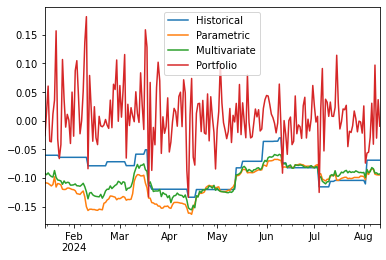

In [67]:
var_data.plot()

<AxesSubplot:>

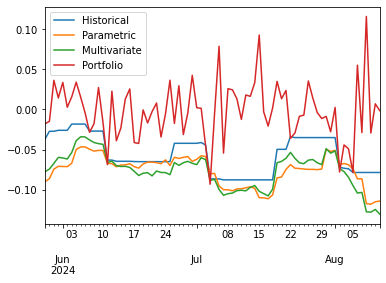

In [68]:
current_var_data.plot()

In [69]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.028436,0.009479,0.014218
Kupiec Stat,2.430111,10.8077,7.835787
P-value,0.119024,0.001011,0.005122


In [70]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.092105,0.052632,0.039474
Kupiec Stat,2.296698,0.010901,0.190499
P-value,0.129649,0.916846,0.662502


## Principal Component Analysis

In [71]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77549969, 0.0718144 , 0.05908865, 0.05228924, 0.04130802])

In [72]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.64752719, 0.15277311, 0.08909766, 0.07677982, 0.03382221])

In [73]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))

<AxesSubplot:>

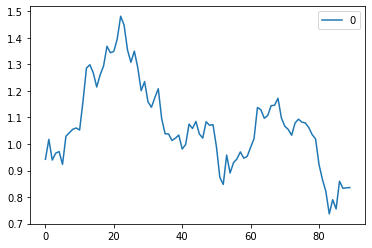

In [74]:
x=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)))
x=x.dropna()
(1+x).cumprod().plot()

<AxesSubplot:>

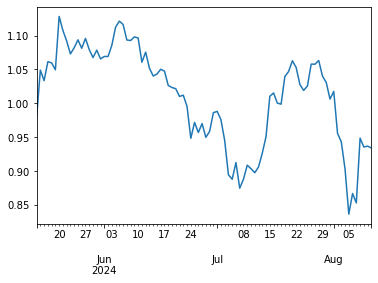

In [75]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [76]:
positions

,BTCUSDT,ETHUSDT,FDUSDUSDT,FETUSDT,INJUSDT,MKRUSDT,RNDRUSDT,SOLUSDT,TNSRUSDT,TRXUSDT,...,XRPUSDT,ARUSDT,ENSUSDT,JASMYUSDT,LDUMAUSDT,LPTUSDT,NOTUSDT,EURUSDT,OMUSDT,Total
2024-05-14,108.786488,39.610745,0.0,13.986206,23.113368,18.301372,42.606286,119.262037,14.497446,10.453518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,414.202819
2024-05-16,115.248436,40.473488,0.0,15.955786,25.364108,18.390147,42.640249,133.842113,15.492836,10.421979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,440.976658
2024-05-20,126.221886,50.329408,0.0,16.970913,30.558124,21.620202,46.155395,156.840658,0.000000,10.387137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,482.411524
2024-05-21,123.928266,52.086233,0.0,17.697309,29.908872,20.930487,47.522396,149.669115,0.000000,10.322871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,475.193747
2024-05-23,120.079262,52.003903,0.0,16.543069,28.274921,19.380333,43.451110,148.019083,0.000000,9.636823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,458.919878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-06,712.269998,170.659638,0.0,0.000000,0.000000,0.000000,NaN,211.877521,0.000000,0.057719,...,0.0,0.0,0.0,271.721235,NaN,0.0,0.0,0.0,214.076342,1728.311347
2024-08-07,700.981775,162.441201,0.0,0.000000,0.000000,0.000000,NaN,212.426185,0.000000,0.059520,...,0.0,0.0,0.0,260.719339,NaN,0.0,0.0,0.0,201.446899,1678.161892
2024-08-08,784.282462,185.994759,0.0,0.000000,0.000000,0.000000,NaN,239.372964,0.000000,0.061832,...,0.0,0.0,0.0,295.643961,NaN,0.0,0.0,0.0,215.824074,1884.338581
2024-08-09,NaN,180.189920,0.0,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.063692,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,206.731707,495.328263


(-0.07002880608451217, -0.0839331110467244)